vf 08: Ensemble com Voting Classifier dos modelos com melhores hiperparâmetros.

# Classificação de lançamentos contábeis

1) Descrição do problema: classificar a despesa pública natureza 339036 (outros serviços - pessoa física) com base no histórico da nota de empenho como fato gerador, ou não, das contribuições previdenciárias.

2) Descrição da solução: Construção de features com base no texto do histórico das notas de empenho, treinamento e teste para seleção do modelo de classificação com melhor métrica de desempenho.

3) Fonte de dados: Os dados das notas de empenho estão disponíveis em portais da transparência de diversos órgãos públicos, por exemplo,
https://www.governotransparente.com.br/acessoinfo/44529487/empenhoportipo. No caso, será utilizada uma base de dados rotulados a partir desses dados públicos.

4) Variáveis independentes: texto com o histórico da nota de empenho.

5) Variável dependente. Primeiramente, será classificado apenas como 0 (não é fato gerador) e 1 (é fato gerador). Posteriormente, a classificação incluirá a categoria do segurado: segurado empregado, contribuinte individual, contribuinte individual – condutor autônomo.

## 1. Carregamento dos dados e importação das bibliotecas

In [1]:
# Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Carrega os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importa bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import joblib

# Configurações
pd.set_option('display.max_colwidth', None)

In [3]:
# Importa os dados
df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')
df_completo.head()

,descricao,fato_gerador,categoria,descricao_limpa,descricao_lematizada
0,Pagamento Referente Aos Serviços De Transporte De Técnicos Durante Supervisão Escolar Nas Escolas Da Zona Rural Deste Município. Referente Ao Mês De Agosto De 2020.,Sim,CA,transporte técnicos supervisão escolar escolas deste,transporte técnico supervisão escolar escola de este
1,"Pagamento Referente Aos Serviços De Transporte De Técnicos Da Secretaria De Educação, Durante Supervisão Escolar Em Unidades Escolares Da Rede Municipal De Ensino. Referente Ao Mês De Maio De 2020.",Sim,CA,transporte técnicos educação supervisão escolar unidades escolares rede,transporte técnico Educação supervisão escolar unidade escolar rede
2,Serviços De Transporte De Infraestrutura Deste Municipio.,Sim,CA,transporte infraestrutura deste municipio,transporte infraestrutura de este municipio
3,Pagamento Referente Aos Serviços De Transporte De Materiais De Expediente Para Atender As Escolas Da Rede Municipal De Ensino.,Sim,CA,transporte materiais expediente escolas rede,transporte material expediente escola rede
4,Serviços De Transportes De Materiais Para Serviços De Infraestrutura Urbana Para Atender As Necessidades As Necessidades Município.,Sim,CA,transportes materiais infraestrutura urbana necessidades necessidades,transporte material infraestrutura urbano necessidade necessidades


In [4]:
# Construção de dataframe com as colunas de interesse
df = df_completo[['descricao_lematizada', 'fato_gerador', 'categoria']]
df.head()

,descricao_lematizada,fato_gerador,categoria
0,transporte técnico supervisão escolar escola de este,Sim,CA
1,transporte técnico Educação supervisão escolar unidade escolar rede,Sim,CA
2,transporte infraestrutura de este municipio,Sim,CA
3,transporte material expediente escola rede,Sim,CA
4,transporte material infraestrutura urbano necessidade necessidades,Sim,CA


In [5]:
df['categoria'].value_counts()

,count
categoria,
CI,28259
Não,7873
CA,2090
SE,485


## 2. Importação dos modelos com melhores hiperparâmetros

In [6]:
# Regressão Logística
reglog = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model.pkl')
reglog_1 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model_1.pkl')
reglog_2 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model_2.pkl')

# Árvore de Decisão
dectree = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/dectree_best_model.pkl')
dectree_1 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/dectree_best_model_1.pkl')
dectree_2 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/dectree_best_model_2.pkl')

# Random Forest
rndforest = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/rndforest_best_model.pkl')
rndforest_1 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/rndforest_best_model_1.pkl')
rndforest_2 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/rndforest_best_model_2.pkl')

# SGDClassifier
sgd = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/sgd_best_model.pkl')
sgd_1 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/sgd_best_model_1.pkl')
sgd_2 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/sgd_best_model_2.pkl')

# XGBClassifier
xgb = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model.pkl')
xgb_1 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model_1.pkl')
xgb_2 = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model_2.pkl')

## 3. Ensemble com Voting Classifier

### 3.1. Classificação em 1 etapa (fato gerador e categoria simultaneamente)

In [27]:
# Divisão do dataset completo em treino e teste
X = df['descricao_lematizada']
y = df['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
y_train = y_train.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})
y_test = y_test.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})

#### 3.1.1. Hard Voting

In [8]:
# Ensemble com Voting Classifier utilizando os modelos com melhores hiperparâmetros

# Voting='hard' decide pelo voto majoritário
voting_clf_hard = VotingClassifier(
    estimators=[
        ('reglog', reglog),
        ('dectree', dectree),
        ('rndforest', rndforest),
        ('sgd', sgd),
        ('xgb', xgb)
    ],
    voting='hard'
)

In [9]:
# Ajuste do ensemble com voting hard
voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               LogisticRegression(C=100,
                                                                  max_iter=3000,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('dectree',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               DecisionTreeClassifier(max_depth=30,
                                                                      min_impurity_decrease=0.0017113920900264177,
                                                                      min_samples_leaf=...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.018877457901429077,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='multi:softprob', ...))]))])

F1-Score balanceado: 0.9935608855170888
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2362
           1       0.99      0.97      0.98       627
           2       0.99      1.00      1.00      8478
           3       0.90      0.97      0.93       146

    accuracy                           0.99     11613
   macro avg       0.97      0.98      0.98     11613
weighted avg       0.99      0.99      0.99     11613



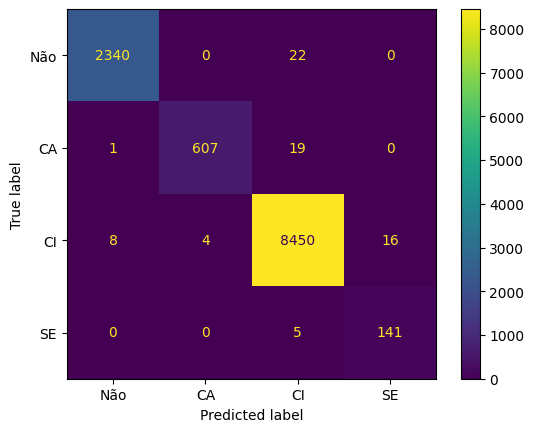

In [28]:
# Predição e avaliação do resultado com voting hard
y_pred_hard = voting_clf_hard.predict(X_test)

print("F1-Score balanceado:", f1_score(y_test, y_pred_hard, average='weighted'))
print(classification_report(y_test, y_pred_hard))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hard, display_labels=['Não', 'CA', 'CI', 'SE'])

In [11]:
# Construção de dataframe para conferência das previsões e respectivas probabilidades
df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['prediction'] = y_pred_hard
df_check['target'] = df_check['target'].map({0: 'Não', 1: 'CA', 2: 'CI', 3: 'SE'})
df_check['prediction'] = df_check['prediction'].map({0: 'Não', 1: 'CA', 2: 'CI', 3: 'SE'})

# Listar as previsões erradas
df_error = df_check[df_check['target'] != df_check['prediction']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 75


,descricao_lematizada,target,prediction
31073,auxilio financeiro cobrir despesa compra medicamento,Não,CI
32130,carro alugar educação de este,Não,CI
685,logisticar saúde de este municipio,CA,CI
10367,contribuição financeiro conceder custear despesa taxa arbitragemo fefuspa onde acontecerar jogo selecao baionense futsal contra selecao Goianesia sera realizar Ginasio higino Ramos de este municipio,CI,Não
30756,ser hotelaria destinar pessoal administracao publico,Não,CI
...,...,...,...
27634,digitador setor contábil relacionar rede,CI,SE
11414,ser fornecimento xerox documento necessidade sec exec fazendo,CI,Não
27256,digitador setor contábil relacionar rede,CI,SE
8,motorista veiculo pesado lotar saber,CA,CI


#### 3.1.2. Soft Voting

In [12]:
# Voting='soft' decide com base na média das probabilidades
voting_clf_soft = VotingClassifier(
    estimators=[
        ('reglog', reglog),
        ('dectree', dectree),
        ('rndforest', rndforest),
        ('sgd', sgd),
        ('xgb', xgb)
    ],
    voting='soft'
)

In [13]:
# Ajuste do ensemble com voting soft
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               LogisticRegression(C=100,
                                                                  max_iter=3000,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('dectree',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               DecisionTreeClassifier(max_depth=30,
                                                                      min_impurity_decrease=0.0017113920900264177,
                                                                      min_samples_leaf=...
                                                             interaction_constraints=None,
                                                             learning_rate=0.018877457901429077,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='multi:softprob', ...))]))],
                 voting='soft')

F1-Score balanceado: 0.9946014625075633
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2362
           1       0.99      0.98      0.99       627
           2       1.00      1.00      1.00      8478
           3       0.90      0.97      0.93       146

    accuracy                           0.99     11613
   macro avg       0.97      0.98      0.98     11613
weighted avg       0.99      0.99      0.99     11613



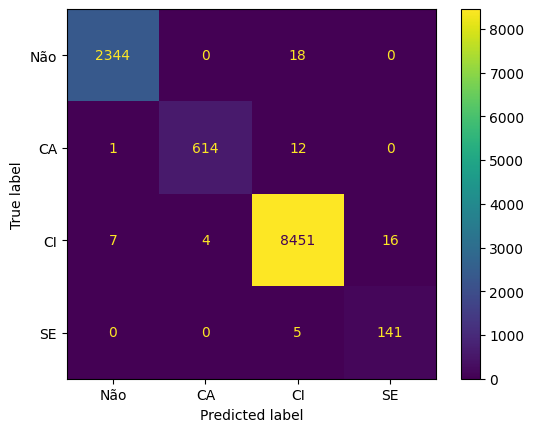

In [29]:
# Avaliação do resultado com voting soft
y_pred_soft = voting_clf_soft.predict(X_test)

print("F1-Score balanceado:", f1_score(y_test, y_pred_soft, average='weighted'))
print(classification_report(y_test, y_pred_soft))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_soft, display_labels=['Não', 'CA', 'CI', 'SE'])

In [15]:
# Cálculo das probabilidades de cada classe
# O cálculo das probabilidades é realizado se treinar o ensemble com voting='soft'
prob_pred = voting_clf_soft.predict_proba(X_test)

# Construção de dataframe para conferência das previsões e respectivas probabilidades
df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['prediction'] = y_pred_soft
df_check['target'] = df_check['target'].map({0: 'Não', 1: 'CA', 2: 'CI', 3: 'SE'})
df_check['prediction'] = df_check['prediction'].map({0: 'Não', 1: 'CA', 2: 'CI', 3: 'SE'})
df_check['prob_CA'] = np.round(prob_pred[0:,0],6).tolist()
df_check['prob_CI'] = np.round(prob_pred[0:,1],6).tolist()
df_check['prob_Não'] = np.round(prob_pred[0:,2],6).tolist()
df_check['prob_SE'] = np.round(prob_pred[0:,3],6).tolist()

# Listar as previsões erradas
df_error = df_check[df_check['target'] != df_check['prediction']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 63


,descricao_lematizada,target,prediction,prob_CA,prob_CI,prob_Não,prob_SE
31073,auxilio financeiro cobrir despesa compra medicamento,Não,CI,0.478662,0.007014,0.511693,0.002631
32130,carro alugar educação de este,Não,CI,0.010806,0.068774,0.918670,0.001750
685,logisticar saúde de este municipio,CA,CI,0.010528,0.005631,0.981910,0.001931
10367,contribuição financeiro conceder custear despesa taxa arbitragemo fefuspa onde acontecerar jogo selecao baionense futsal contra selecao Goianesia sera realizar Ginasio higino Ramos de este municipio,CI,Não,0.527244,0.006292,0.464348,0.002117
30756,ser hotelaria destinar pessoal administracao publico,Não,CI,0.446821,0.021334,0.530182,0.001662
...,...,...,...,...,...,...,...
22836,digitador setor contábil relacionar rede,CI,SE,0.006675,0.005372,0.466115,0.521838
27634,digitador setor contábil relacionar rede,CI,SE,0.006675,0.005372,0.466115,0.521838
11414,ser fornecimento xerox documento necessidade sec exec fazendo,CI,Não,0.620158,0.012106,0.366489,0.001247
27256,digitador setor contábil relacionar rede,CI,SE,0.006675,0.005372,0.466115,0.521838


### 3.2. Classificação em 2 etapas

#### 3.1.1. Hard Voting

In [30]:
# Divisão do dataset completo em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']
y_train = y_train.map({'Não': 0, 'Sim': 1})
y_test = y_test.map({'Não': 0, 'Sim': 1})

In [16]:
# Ensemble com Voting Classifier
voting_clf_hard_1 = VotingClassifier(
    estimators=[
        ('reglog_1', reglog_1),
        ('dectree_1', dectree_1),
        ('rndforest_1', rndforest_1),
        ('sgd_1', sgd_1),
        ('xgb_1', xgb_1)
    ],
    voting='hard'
)

# Ajuste do ensemble com voting hard
voting_clf_hard_1.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog_1',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('classifier',
                                               LogisticRegression(C=10,
                                                                  max_iter=3000,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('dectree_1',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               DecisionTreeClassifier(max_depth=30,
                                                                      min_impurity_decrease=0.001711392090...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.04394909714042285,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=700,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))])

In [31]:
# Recuperação do dataset completo, filtro das observações fato_gerador = 1
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)
df_train = df_train[df_train['fato_gerador'] == 'Sim']
df_test = df_test[df_test['fato_gerador'] == 'Sim']

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']
y_train = y_train.map({'CA': 0, 'CI': 1, 'SE': 2})
y_test = y_test.map({'CA': 0, 'CI': 1, 'SE': 2})

In [17]:
# Ensemble com Voting Classifier
voting_clf_hard_2 = VotingClassifier(
    estimators=[
        ('reglog_2', reglog_2),
        ('dectree_2', dectree_2),
        ('rndforest_2', rndforest_2),
        ('sgd_2', sgd_2),
        ('xgb_2', xgb_2)
    ],
    voting='hard'
)

# Ajuste do ensemble com voting hard
voting_clf_hard_2.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog_2',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               LogisticRegression(C=100,
                                                                  max_iter=3000,
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('dectree_2',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               DecisionTreeClassifier(max_depth=25,
                                                                      min_impurity_decrease=0.0029110607307843983,
                                                                      min_samples_leaf=10))])),
                             (...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.022366299482641024,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='multi:softprob', ...))]))])

In [32]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

df_test['fg_pred'] = voting_clf_hard_1.predict(df_test['descricao_lematizada'])
df_test['fg_pred'] = df_test['fg_pred'].map({0: 'Não', 1: 'Sim'})

df_test_sim = df_test[df_test['fg_pred'] == 'Sim']
df_test_sim['cat_pred'] = voting_clf_hard_2.predict(df_test_sim['descricao_lematizada'])
df_test_sim['cat_pred'] = df_test_sim['cat_pred'].map({0: 'CA', 1: 'CI', 2: 'SE'})

df_test_nao = df_test[df_test['fg_pred'] == 'Não']
df_test_nao['cat_pred'] = 'Não'

df_test = pd.concat([df_test_sim, df_test_nao], ignore_index=True)

<ipython-input-32-0b7b1d86b8ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = voting_clf_hard_2.predict(df_test_sim['descricao_lematizada'])
<ipython-input-32-0b7b1d86b8ab>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = df_test_sim['cat_pred'].map({0: 'CA', 1: 'CI', 2: 'SE'})
<ipython-input-32-0b7b1d86b8ab>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

F1-Score balanceado: 0.9933058231836439
              precision    recall  f1-score   support

          CA       0.99      0.98      0.99       627
          CI       0.99      1.00      1.00      8478
         Não       1.00      0.99      0.99      2362
          SE       0.89      0.95      0.92       146

    accuracy                           0.99     11613
   macro avg       0.97      0.98      0.97     11613
weighted avg       0.99      0.99      0.99     11613



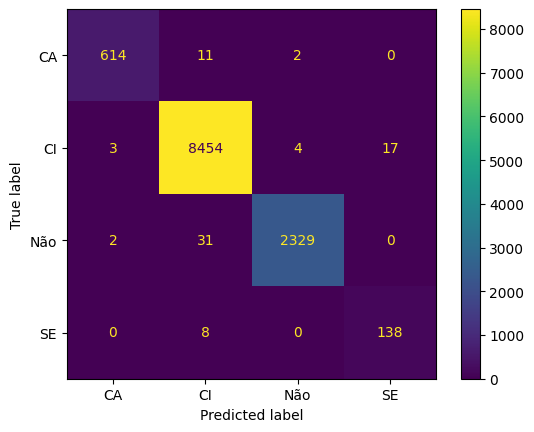

In [33]:
# Métricas de avaliação da predição
print('F1-Score balanceado:', f1_score(df_test['categoria'], df_test['cat_pred'], average='weighted'))
print(classification_report(df_test['categoria'], df_test['cat_pred']))
ConfusionMatrixDisplay.from_predictions(df_test['categoria'], df_test['cat_pred'])

In [20]:
# Listar as previsões erradas
df_error = df_test[df_test['categoria'] != df_test['cat_pred']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 78


,descricao_lematizada,fato_gerador,categoria,fg_pred,cat_pred
12,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
444,aluquel social,Não,Não,Sim,CI
504,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
666,anulacao parcial empenho anulacao ne fazer grande em este data complementação empenho dia,Não,Não,Sim,CI
711,servico prestar taxista segaf,Sim,CA,Sim,CI
...,...,...,...,...,...
10267,ser locação levar trazer correspondencia saude baiao regional,Sim,CA,Não,Não
10372,p fazer face despesa servico preparacao fornecimento algodao doce evento programa crianca feliz conforme aditivo contrato n,Sim,CI,Não,Não
10702,ser marceneiro fornecimento material divisoria casa onde ir funcionar sede seab urbanismo,Sim,CI,Não,Não
10790,ser locação levar trazer correspondencia saude baiao regional,Sim,CA,Não,Não


#### 3.1.1. Soft Voting

In [34]:
# Divisão do dataset completo em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']
y_train = y_train.map({'Não': 0, 'Sim': 1})
y_test = y_test.map({'Não': 0, 'Sim': 1})

In [21]:
# Ensemble com Voting Classifier
voting_clf_soft_1 = VotingClassifier(
    estimators=[
        ('reglog_1', reglog_1),
        ('dectree_1', dectree_1),
        ('rndforest_1', rndforest_1),
        ('sgd_1', sgd_1),
        ('xgb_1', xgb_1)
    ],
    voting='soft'
)

# Ajuste do ensemble com voting soft
voting_clf_soft_1.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog_1',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('classifier',
                                               LogisticRegression(C=10,
                                                                  max_iter=3000,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('dectree_1',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               DecisionTreeClassifier(max_depth=30,
                                                                      min_impurity_decrease=0.001711392090...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.04394909714042285,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=700,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))],
                 voting='soft')

In [35]:
# Recuperação do dataset completo, filtro das observações fato_gerador = 1
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)
df_train = df_train[df_train['fato_gerador'] == 'Sim']
df_test = df_test[df_test['fato_gerador'] == 'Sim']

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']
y_train = y_train.map({'CA': 0, 'CI': 1, 'SE': 2})
y_test = y_test.map({'CA': 0, 'CI': 1, 'SE': 2})

In [22]:
# Ensemble com Voting Classifier
voting_clf_soft_2 = VotingClassifier(
    estimators=[
        ('reglog_2', reglog_2),
        ('dectree_2', dectree_2),
        ('rndforest_2', rndforest_2),
        ('sgd_2', sgd_2),
        ('xgb_2', xgb_2)
    ],
    voting='soft'
)

# Ajuste do ensemble com voting soft
voting_clf_soft_2.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog_2',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               LogisticRegression(C=100,
                                                                  max_iter=3000,
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('dectree_2',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('classifier',
                                               DecisionTreeClassifier(max_depth=25,
                                                                      min_impurity_decrease=0.0029110607307843983,
                                                                      min_samples_leaf=10))])),
                             (...
                                                             interaction_constraints=None,
                                                             learning_rate=0.022366299482641024,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='multi:softprob', ...))]))],
                 voting='soft')

In [36]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

df_test['fg_pred'] = voting_clf_soft_1.predict(df_test['descricao_lematizada'])
df_test['fg_pred'] = df_test['fg_pred'].map({0: 'Não', 1: 'Sim'})

df_test_sim = df_test[df_test['fg_pred'] == 'Sim']
df_test_sim['cat_pred'] = voting_clf_soft_2.predict(df_test_sim['descricao_lematizada'])
df_test_sim['cat_pred'] = df_test_sim['cat_pred'].map({0: 'CA', 1: 'CI', 2: 'SE'})

df_test_nao = df_test[df_test['fg_pred'] == 'Não']
df_test_nao['cat_pred'] = 'Não'

df_test = pd.concat([df_test_sim, df_test_nao], ignore_index=True)

<ipython-input-36-bdb55b5d5e55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = voting_clf_soft_2.predict(df_test_sim['descricao_lematizada'])
<ipython-input-36-bdb55b5d5e55>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = df_test_sim['cat_pred'].map({0: 'CA', 1: 'CI', 2: 'SE'})
<ipython-input-36-bdb55b5d5e55>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

F1-Score balanceado: 0.9939132026276277
              precision    recall  f1-score   support

          CA       0.99      0.99      0.99       627
          CI       0.99      1.00      1.00      8478
         Não       1.00      0.99      0.99      2362
          SE       0.89      0.95      0.92       146

    accuracy                           0.99     11613
   macro avg       0.97      0.98      0.97     11613
weighted avg       0.99      0.99      0.99     11613



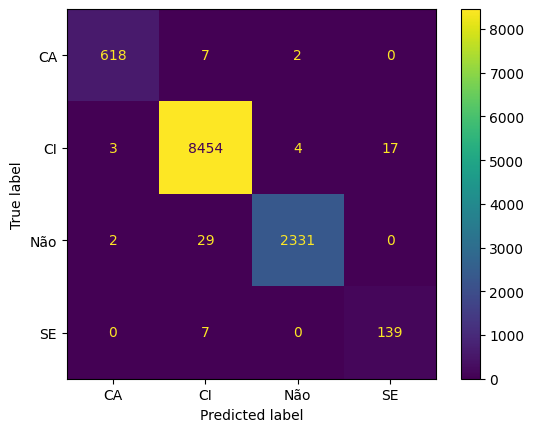

In [37]:
# Métricas de avaliação da predição
print('F1-Score balanceado:', f1_score(df_test['categoria'], df_test['cat_pred'], average='weighted'))
print(classification_report(df_test['categoria'], df_test['cat_pred']))
ConfusionMatrixDisplay.from_predictions(df_test['categoria'], df_test['cat_pred'])

In [25]:
# Listar as previsões erradas
df_error = df_test[df_test['categoria'] != df_test['cat_pred']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 71


,descricao_lematizada,fato_gerador,categoria,fg_pred,cat_pred
12,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
444,aluquel social,Não,Não,Sim,CI
504,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
666,anulacao parcial empenho anulacao ne fazer grande em este data complementação empenho dia,Não,Não,Sim,CI
711,servico prestar taxista segaf,Sim,CA,Sim,CI
...,...,...,...,...,...
10268,ser locação levar trazer correspondencia saude baiao regional,Sim,CA,Não,Não
10373,p fazer face despesa servico preparacao fornecimento algodao doce evento programa crianca feliz conforme aditivo contrato n,Sim,CI,Não,Não
10703,ser marceneiro fornecimento material divisoria casa onde ir funcionar sede seab urbanismo,Sim,CI,Não,Não
10791,ser locação levar trazer correspondencia saude baiao regional,Sim,CA,Não,Não
